##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 3 - Function calling with the Gemini API

Welcome back to the Kaggle 5-day Generative AI course!

In this notebook, you will use the Gemini API's automatic function calling to build a chat interface over a local database. This example is a toy and is missing a number of safety and security constraints you would use in a real-world example, but shows how to add AI chat capabilities to existing applications with ease.

## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## Setup

Start by installing and importing the Python SDK.

In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

In [2]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
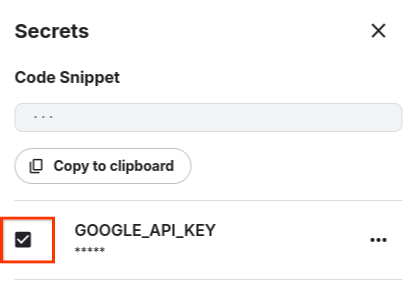

### Automated retry

In [4]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Create a local database

For this minimal example, you'll create a local SQLite database and add some synthetic data so you have something to query.

Load the `sql` IPython extension so you can interact with the database using magic commands (the `%` instructions) to create a new, empty SQLite database.

In [5]:
%load_ext sql
%sql sqlite:///sample.db

Create the tables and insert some synthetic data. Feel free to tweak this structure and data.

In [6]:
%%sql
-- Create the 'products' table
CREATE TABLE IF NOT EXISTS products (
  	product_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	product_name VARCHAR(255) NOT NULL,
  	price DECIMAL(10, 2) NOT NULL
  );

-- Create the 'staff' table
CREATE TABLE IF NOT EXISTS staff (
  	staff_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	first_name VARCHAR(255) NOT NULL,
  	last_name VARCHAR(255) NOT NULL
  );

-- Create the 'orders' table
CREATE TABLE IF NOT EXISTS orders (
  	order_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	customer_name VARCHAR(255) NOT NULL,
  	staff_id INTEGER NOT NULL,
  	product_id INTEGER NOT NULL,
  	FOREIGN KEY (staff_id) REFERENCES staff (staff_id),
  	FOREIGN KEY (product_id) REFERENCES products (product_id)
  );

-- Insert data into the 'products' table
INSERT INTO products (product_name, price) VALUES
  	('Laptop', 799.99),
  	('Keyboard', 129.99),
  	('Mouse', 29.99);

-- Insert data into the 'staff' table
INSERT INTO staff (first_name, last_name) VALUES
  	('Alice', 'Smith'),
  	('Bob', 'Johnson'),
  	('Charlie', 'Williams');

-- Insert data into the 'orders' table
INSERT INTO orders (customer_name, staff_id, product_id) VALUES
  	('David Lee', 1, 1),
  	('Emily Chen', 2, 2),
  	('Frank Brown', 1, 3);

 * sqlite:///sample.db
Done.
Done.
Done.
3 rows affected.
3 rows affected.
3 rows affected.


[]

## Define database functions

Function calling with Gemini API's Python SDK can be implemented by defining [an OpenAPI schema](https://ai.google.dev/api/caching#Schema) that is passed to the model. You can also define Python functions and let the SDK inspect them to automatically define the schema. In this latter case, it's important that the functions are type annotated and have accurate docstrings that describe what the functions do - the model has no insight into the function body, so the docs function as the interface.

By providing three key pieces of functionality - listing tables, describing a table, and executing a query - the LLM (much like a human user) will have the basic tools needed to understand and interrogate the database.

Start with a database connection that will be used across all of the functions.

In [7]:
import sqlite3

db_file = "sample.db"
db_conn = sqlite3.connect(db_file)

The first function will list all tables available in the database. Define it, and test it out to ensure it works.

In [8]:
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables()')

    cursor = db_conn.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]


list_tables()

 - DB CALL: list_tables()


['products', 'sqlite_sequence', 'staff', 'orders']

Once the available tables is known, the next step a database user will need is to understand what columns are available in a given table. Define that too, and test that it works as expected.

In [9]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = db_conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


describe_table("products")

 - DB CALL: describe_table(products)


[('product_id', 'INTEGER'),
 ('product_name', 'VARCHAR(255)'),
 ('price', 'DECIMAL(10, 2)')]

Now that the system knows what tables and columns are present, it has enough information to be able to generate and run a `SELECT` query. Now provide that functionality, and test that it works.

In [10]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: execute_query({sql})')

    cursor = db_conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()


execute_query("select * from products")

 - DB CALL: execute_query(select * from products)


[(1, 'Laptop', 799.99), (2, 'Keyboard', 129.99), (3, 'Mouse', 29.99)]

## Implement function calls

Now you can put it all together in a call to the Gemini API.

Function calling works by adding specific messages to a chat session. When function schemas are defined and made available to the model and a conversation is started, instead of returning a text response, the model may return a `function_call` instead. When this happens, the client must respond with a `function_response`, indicating the result of the call, and the conversation can continue on as normal.

This function calling interaction normally happens manually, allowing you, the client, to validate and initiate the call. However the Python SDK also supports **automatic function calling**, where the supplied functions will be automatically invoked. This is a powerful feature and should be used with care, such as when the functions have no [side-effects](https://en.wikipedia.org/wiki/Side_effect_(computer_science)).

Here's the state diagram representing the conversation flow with function calling. With automatic function calling, the bottom row is executed automatically by the Python SDK. With manual function calling, you write the code to run each step individually.

![function calling state diagram](https://codelabs.developers.google.com/static/codelabs/gemini-function-calling/img/gemini-function-calling-overview_1440.png)

In [11]:
# These are the Python functions defined above.
db_tools = [list_tables, describe_table, execute_query]

instruction = """You are a helpful chatbot that can interact with an SQL database
for a computer store. You will take the users questions and turn them into SQL
queries using the tools available. Once you have the information you need, you will
answer the user's question using the data returned.

Use list_tables to see what tables are present, describe_table to understand the
schema, and execute_query to issue an SQL SELECT query."""

client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

Now you can engage in a chat conversation where you can ask about the contents of the database.

In [12]:
resp = chat.send_message("What is the cheapest product?")
print(f"\n{resp.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(products)
 - DB CALL: execute_query(SELECT product_name, price FROM products ORDER BY price ASC LIMIT 1)

The cheapest product is the Mouse, which costs $29.99.


Explore the chat session and ask your own questions. The 2.0 models are quite capable and can usually answer questions requiring multiple steps.

In [13]:
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

response = chat.send_message('What products should salesperson Alice focus on to round out her portfolio? Explain why.')
print(f"\n{response.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(products)
 - DB CALL: describe_table(staff)
 - DB CALL: describe_table(orders)
 - DB CALL: execute_query(SELECT product_name FROM products EXCEPT SELECT T1.product_name FROM products AS T1 INNER JOIN orders AS T2 ON T1.product_id = T2.product_id INNER JOIN staff AS T3 ON T2.staff_id = T3.staff_id WHERE T3.first_name = 'Alice')

Alice should focus on selling Keyboards. Currently, she has not sold any keyboards, so adding this product to her portfolio would round it out.


### Inspecting the conversation

To see the calls that the model makes, and what the client returns in response, you can inspect the chat history. This helper function will print out each turn along with the relevant fields passed or returned.

In [14]:
import textwrap


def print_chat_turns(chat):
    """Prints out each turn in the chat history, including function calls and responses."""
    for event in chat.get_history():
        print(f"{event.role.capitalize()}:")

        for part in event.parts:
            if txt := part.text:
                print(f'  "{txt}"')
            elif fn := part.function_call:
                args = ", ".join(f"{key}={val}" for key, val in fn.args.items())
                print(f"  Function call: {fn.name}({args})")
            elif resp := part.function_response:
                print("  Function response:")
                print(textwrap.indent(str(resp.response['result']), "    "))

        print()


print_chat_turns(chat)

User:
  "What products should salesperson Alice focus on to round out her portfolio? Explain why."

Model:
  Function call: list_tables()

User:
  Function response:
    ['products', 'sqlite_sequence', 'staff', 'orders']

Model:
  Function call: describe_table(table_name=products)

User:
  Function response:
    [('product_id', 'INTEGER'), ('product_name', 'VARCHAR(255)'), ('price', 'DECIMAL(10, 2)')]

Model:
  Function call: describe_table(table_name=staff)

User:
  Function response:
    [('staff_id', 'INTEGER'), ('first_name', 'VARCHAR(255)'), ('last_name', 'VARCHAR(255)')]

Model:
  Function call: describe_table(table_name=orders)

User:
  Function response:
    [('order_id', 'INTEGER'), ('customer_name', 'VARCHAR(255)'), ('staff_id', 'INTEGER'), ('product_id', 'INTEGER')]

Model:
  Function call: execute_query(sql=SELECT product_name FROM products EXCEPT SELECT T1.product_name FROM products AS T1 INNER JOIN orders AS T2 ON T1.product_id = T2.product_id INNER JOIN staff AS T3 ON T2

In this output you can see each of the conversational turns that were made. Note that the model doesn't remember anything outside of the chat history, so you can make changes to the database structure or data and the model will respond without needing any code changes - try this out!

## Compositional function calling

A powerful new feature in Gemini 2.0 is the model's ability to compose user-provided function calls together while generating code.

This means that the model is able to take the available tools, generate code that uses it, and execute it all.

The feature requires the Live API, so this step uses different setup code than most of the examples you have seen so far. As the Multimodal Live API is a bi-directional streaming service, everything is set up in advance and then executed. This is a little more complex but the result is quite powerful.

First define a function that will handle streaming model output. It will stream text output, handle tool-calling and show the generated code that the model writes and executes to fulfill the task.

In [15]:
from pprint import pformat
from IPython.display import display, Image, Markdown


async def handle_response(stream, tool_impl=None):
  """Stream output and handle any tool calls during the session."""
  all_responses = []

  async for msg in stream.receive():
    all_responses.append(msg)

    if text := msg.text:
      # Output any text chunks that are streamed back.
      if len(all_responses) < 2 or not all_responses[-2].text:
        # Display a header if this is the first text chunk.
        display(Markdown('### Text'))

      print(text, end='')

    elif tool_call := msg.tool_call:
      # Handle tool-call requests.
      for fc in tool_call.function_calls:
        display(Markdown('### Tool call'))

        # Execute the tool and collect the result to return to the model.
        if callable(tool_impl):
          try:
            result = tool_impl(**fc.args)
          except Exception as e:
            result = str(e)
        else:
          result = 'ok'

        tool_response = types.LiveClientToolResponse(
            function_responses=[types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': result},
            )]
        )
        await stream.send(input=tool_response)

    elif msg.server_content and msg.server_content.model_turn:
      # Print any messages showing code the model generated and ran.

      for part in msg.server_content.model_turn.parts:
          if code := part.executable_code:
            display(Markdown(
                f'### Code\n```\n{code.code}\n```'))

          elif result := part.code_execution_result:
            display(Markdown(f'### Result: {result.outcome}\n'
                             f'```\n{pformat(result.output)}\n```'))

          elif img := part.inline_data:
            display(Image(img.data))

  print()
  return all_responses

### Textual live database chat

Now connect to the model and start a conversation.

The Live API is a streaming API, so this example is fully pre-scripted and only has a single user input. Despite this, the request still requires the model to perform a bit of back-and-forth to interrogate the database, and you should see the model generate some code that uses the `execute_query` tool in a loop.

In [16]:
model = 'gemini-2.0-flash-exp'
live_client = genai.Client(api_key=GOOGLE_API_KEY,
                           http_options=types.HttpOptions(api_version='v1alpha'))

# Wrap the existing execute_query tool you used in the earlier example.
execute_query_tool_def = types.FunctionDeclaration.from_callable(
    client=live_client, callable=execute_query)

# Provide the model with enough information to use the tool, such as describing
# the database so it understands which SQL syntax to use.
sys_int = """You are a database interface. Use the `execute_query` function
to answer the users questions by looking up information in the database,
running any necessary queries and responding to the user.

You need to look up table schema using sqlite3 syntax SQL, then once an
answer is found be sure to tell the user. If the user is requesting an
action, you must also execute the actions.
"""

config = {
    "response_modalities": ["TEXT"],
    "system_instruction": {"parts": [{"text": sys_int}]},
    "tools": [
        {"code_execution": {}},
        {"function_declarations": [execute_query_tool_def.to_json_dict()]},
    ],
}

async with live_client.aio.live.connect(model=model, config=config) as session:

  message = "Please generate and insert 5 new rows in the orders table."
  print(f"> {message}\n")

  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

/tmp/ipykernel_30/3415874943.py:29: ExperimentalWarning: The live API is experimental and may change in future versions.
  async with live_client.aio.live.connect(model=model, config=config) as session:


> Please generate and insert 5 new rows in the orders table.



### Text

I need to understand the structure of the `orders` table before I can insert new rows. I'll start by querying the database schema.


### Code
```
print(default_api.execute_query(sql="PRAGMA table_info(orders);"))

```

### Tool call

 - DB CALL: execute_query(PRAGMA table_info(orders);)


### Result: OUTCOME_OK
```
("{'result': [[0, 'order_id', 'INTEGER', 0, None, 1], [1, 'customer_name', "
 "'VARCHAR(255)', 1, None, 0], [2, 'staff_id', 'INTEGER', 1, None, 0], [3, "
 "'product_id', 'INTEGER', 1, None, 0]]}\n")
```

### Text

Okay, the `orders` table has columns `order_id` (INTEGER, primary key), `customer_name` (VARCHAR(255)), `staff_id` (INTEGER), and `product_id` (INTEGER). I'll now insert 5 new rows into this table, making sure to provide values for `customer_name`, `staff_id`, and `product_id`. I will auto-increment the `order_id`.


### Code
```
insert_statements = [
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Alice Smith', 1, 101);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Bob Johnson', 2, 102);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Charlie Brown', 1, 103);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Diana Prince', 3, 104);",
    "INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Eve Miller', 2, 105);"
]

for stmt in insert_statements:
  print(default_api.execute_query(sql=stmt))

```

### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Alice Smith', 1, 101);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Bob Johnson', 2, 102);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Charlie Brown', 1, 103);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Diana Prince', 3, 104);)


### Tool call

 - DB CALL: execute_query(INSERT INTO orders (customer_name, staff_id, product_id) VALUES ('Eve Miller', 2, 105);)


### Result: OUTCOME_OK
```
("{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n"
 "{'result': []}\n")
```

### Text

I have successfully inserted 5 new rows into the `orders` table.



In the output from the previous step, you should see a `Code` section that shows code that the model generated in order to complete the task. It will look something like this:

```py
sql_statements = [ ... ]

for sql in sql_statements:
  print(default_api.execute_query(sql))
```

The model then runs this code (remotely), calling out to the provided tool when it reaches that part of the code. The `default_api` module contains the tools that you provided.

This example simply executes in a loop, but the models are capable of more complex interactions with multiple tools, giving you a powerful agent framework that's effectively built in to the Gemini API.

### Plotting the database

Try out the built-in agent capability with the next example. You may notice the model try to guess the database schema or environment. Often the model will make mistakes, but you can look through the `Text` output and watch as the model inspects the error, tries a new approach and learns from its mistakes.

If the model doesn't return a plot, try running the cell again.

> Can you figure out the number of orders that were made by each of the staff?



### Code
```
sql_query = "SELECT name FROM sqlite_master WHERE type='table';"
print(default_api.execute_query(sql=sql_query))

```

### Tool call

 - DB CALL: execute_query(SELECT name FROM sqlite_master WHERE type='table';)


### Result: OUTCOME_OK
```
"{'result': [['products'], ['sqlite_sequence'], ['staff'], ['orders']]}\n"
```

### Text

Okay, I see the tables available are `products`, `staff`, and `orders`. To figure out the number of orders made by each staff, I'll need to join the `staff` and `orders` tables, probably using a staff ID. Let's inspect the schemas of both tables.


### Code
```
print(default_api.execute_query(sql="PRAGMA table_info(staff);"))
print(default_api.execute_query(sql="PRAGMA table_info(orders);"))

```

### Tool call

 - DB CALL: execute_query(PRAGMA table_info(staff);)


### Tool call

 - DB CALL: execute_query(PRAGMA table_info(orders);)


### Result: OUTCOME_OK
```
("{'result': [[0, 'staff_id', 'INTEGER', 0, None, 1], [1, 'first_name', "
 "'VARCHAR(255)', 1, None, 0], [2, 'last_name', 'VARCHAR(255)', 1, None, 0]]}\n"
 "{'result': [[0, 'order_id', 'INTEGER', 0, None, 1], [1, 'customer_name', "
 "'VARCHAR(255)', 1, None, 0], [2, 'staff_id', 'INTEGER', 1, None, 0], [3, "
 "'product_id', 'INTEGER', 1, None, 0]]}\n")
```

### Text

Okay, it seems like `staff` table has `staff_id`, `first_name`, and `last_name` columns, and the `orders` table has `order_id`, `customer_name`, `staff_id`, and `product_id`.  I can join these tables on `staff.staff_id = orders.staff_id`. Then I will group by `staff_id` and count the number of orders to fulfill the user request. I will also select `first_name` and `last_name` to show to the user.


### Code
```
sql_query = """
SELECT
    s.first_name,
    s.last_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
"""
print(default_api.execute_query(sql=sql_query))

```

### Tool call

 - DB CALL: execute_query(
SELECT
    s.first_name,
    s.last_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
)


### Result: OUTCOME_OK
```
("{'result': [['Alice', 'Smith', 4], ['Bob', 'Johnson', 3], ['Charlie', "
 "'Williams', 1]]}\n")
```

### Text

Okay, it looks like:
- Alice Smith made 4 orders.
- Bob Johnson made 3 orders.
- Charlie Williams made 1 order.

> Generate and run some code to plot this as a python seaborn chart



### Text

I need to retrieve the data again to plot it using seaborn.


### Code
```
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sql_query = """
SELECT
    s.first_name,
    s.last_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
"""
result = default_api.execute_query(sql=sql_query)
df = pd.DataFrame(result['result'], columns=['first_name', 'last_name', 'number_of_orders'])
df['staff_name'] = df['first_name'] + ' ' + df['last_name']

plt.figure(figsize=(10,6))
sns.barplot(x='staff_name', y='number_of_orders', data=df)
plt.xlabel('Staff Name')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Staff')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

```

### Tool call

 - DB CALL: execute_query(
SELECT
    s.first_name,
    s.last_name,
    COUNT(o.order_id) AS number_of_orders
FROM
    staff s
JOIN
    orders o ON s.staff_id = o.staff_id
GROUP BY
    s.staff_id;
)


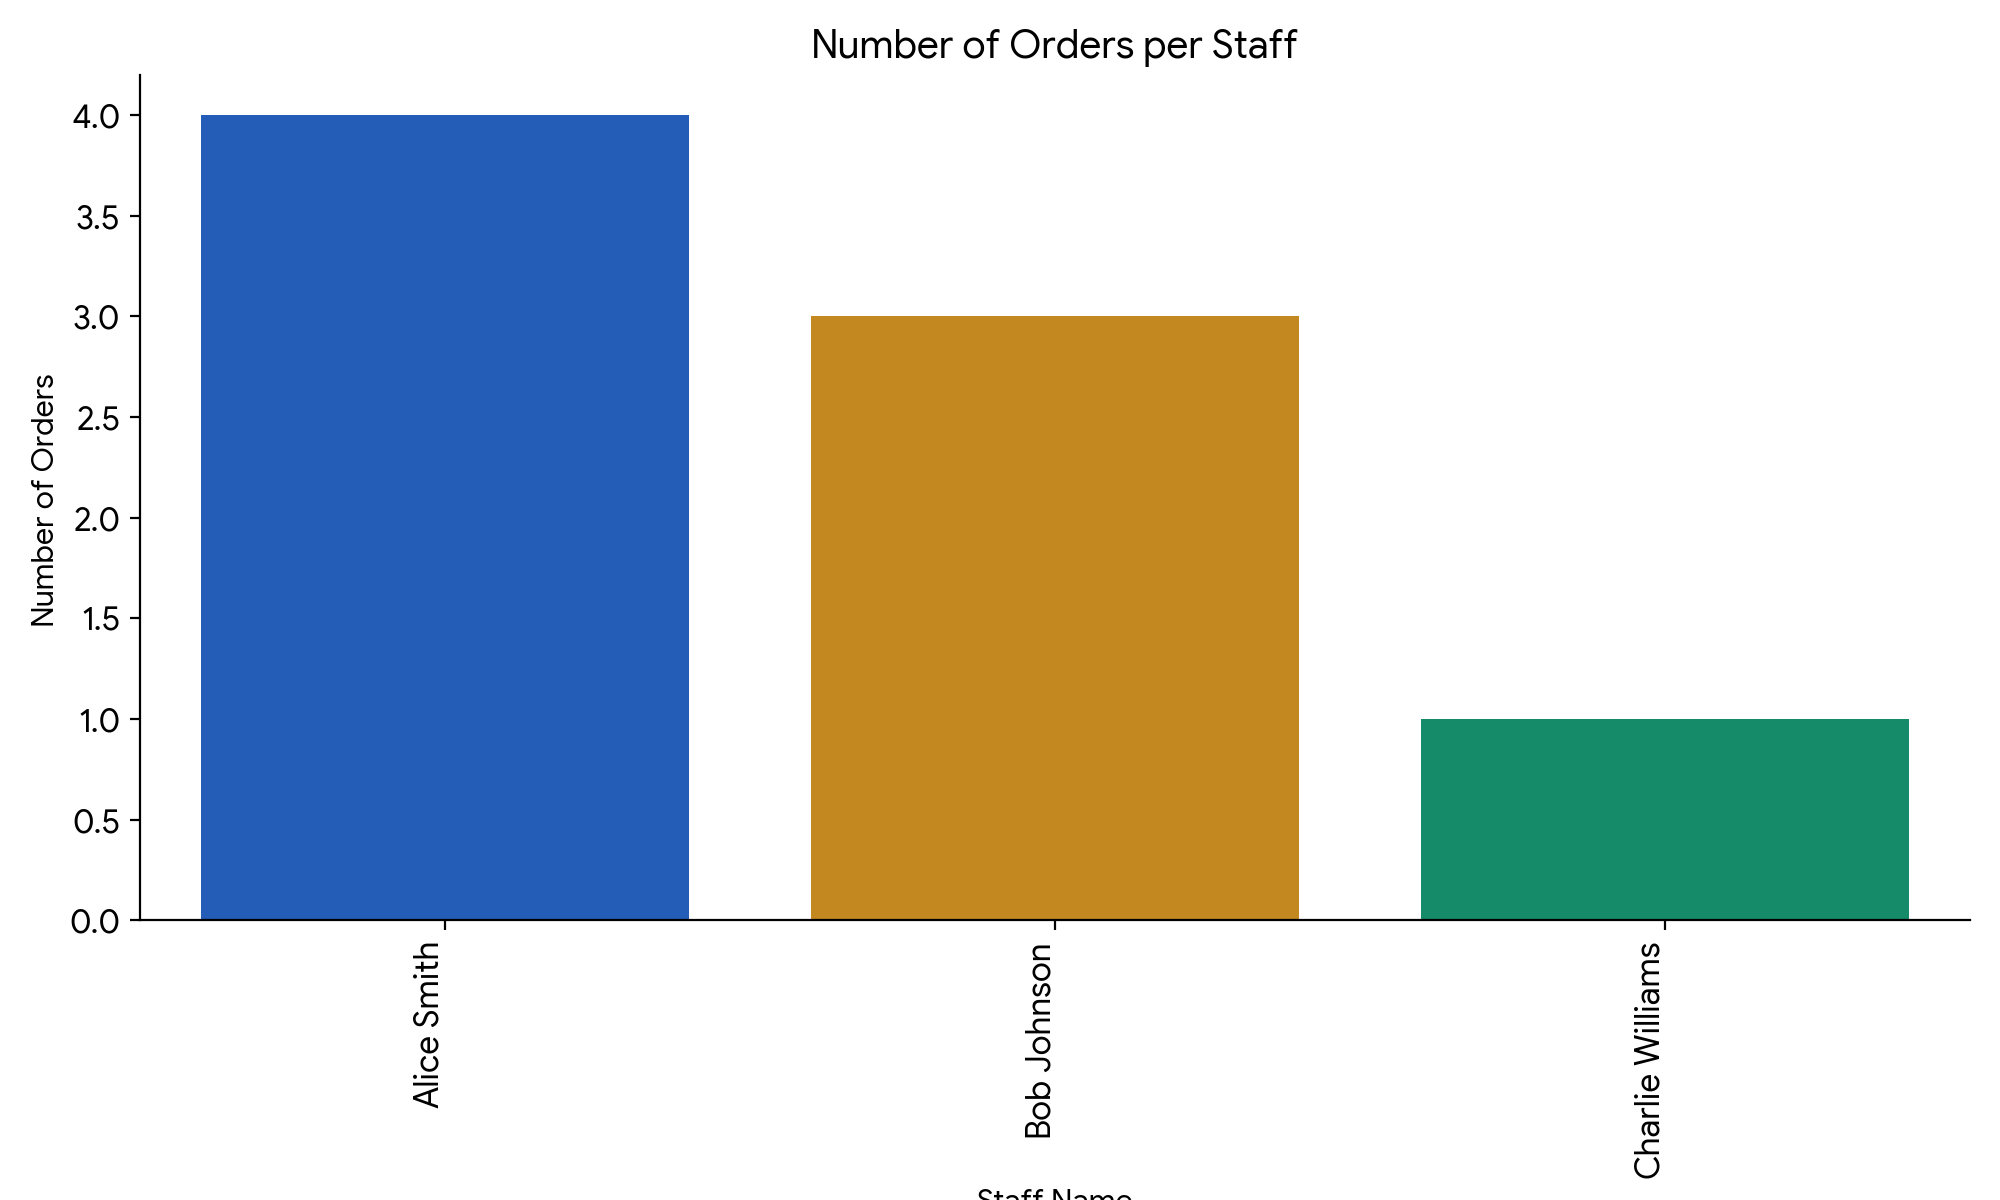

### Text

Okay, the chart is generated and displayed successfully. It visually shows the number of orders made by each staff member (Alice Smith, Bob Johnson, and Charlie Williams).



In [17]:
async with live_client.aio.live.connect(model=model, config=config) as session:

  message = "Can you figure out the number of orders that were made by each of the staff?"

  print(f"> {message}\n")
  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

  message = "Generate and run some code to plot this as a python seaborn chart"

  print(f"> {message}\n")
  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)

## Further reading

To learn more about what the Gemini API can do with function calling, check out the [Function calling cookbook](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Function_calling.ipynb) (see `Manual function calling` to understand how function calling works manually) as well as [Function calling config](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Function_calling_config.ipynb), which gives you fine-grained control over how function calling is triggered.

And stay tuned for day 4, where you will explore using function calling with grounding tools.

*- [Mark McD](https://linktr.ee/markmcd)*